Name - Rahul Keshwani
NetID - ryk248

Name - Arun Kodnani
NetID - ak6484

# Setup

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

# Imports

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import random
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
plt.style.use('fivethirtyeight')

# Utility class for fetching data

In [0]:
class Data():
 
  def __init__(self):
    self.transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    self.trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=self.transform)
    self.Xtrain, self.ytrain = self.splitXandY(self.trainset)

    self.testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=self.transform)
    self.Xtest, self.ytest = self.splitXandY(self.testset)
    
  def splitXandY(self, data):
    x = []
    y = []
    for image in data:
      x.append(image[0].numpy().flatten())
      y.append(image[1])
    x = np.array(x)
    y = np.array(y)
    return x,y
    
  def get_xtrain(self):
    return self.Xtrain
  
  def get_ytrain(self):
    return self.ytrain
  
  def get_xtest(self):
    return self.Xtest
  
  def get_ytest(self):
    return self.ytest
  
  def load_data(self):
    Xtrain = self.get_xtrain()
    ytrain = self.get_ytrain()
    Xtest = self.get_xtest()
    ytest = self.get_ytest()
    return (Xtrain, ytrain, Xtest, ytest)
    

# Neural Network Class

In [0]:
#  Block for functions and classes.
def save_predictions(filename, y):
  """
  Dumps y into .npy file
  """
  np.save(filename, y)

class NeuralNetwork(object):
  def __init__(self, layer_dimensions, drop_prob=0.0, reg_lambda=0.0):
    np.random.seed(1)
    
    self.parameters = {}
    for i in range(1,len(layer_dimensions)):
      self.parameters[i] = [np.random.randn(layer_dimensions[i], layer_dimensions[i-1])*0.01, np.zeros((layer_dimensions[i], 1))]
      
    self.num_layers = len(layer_dimensions)
    self.drop_prob = drop_prob
    self.reg_lambda = reg_lambda
    
    
  def generateClassVector(self, y):
    result = np.zeros(shape=(10,y.shape[0]))
    result[y, range(y.shape[0])] = 1
    return result
  
  def affineForward(self, A, W, b):
    Z = np.dot(W,A) + b
    
    cache = (A, W, b, Z)
    return Z, cache

  def activationForward(self, A, activation): 
    if activation == 'relu':
      return np.maximum(0, A)
    
    if activation == 'softmax':
      y = np.exp(A - np.max(A))
      return y/y.sum(axis=0)
  
  def forwardPropagation(self, X):
    allCache = []
    A = X
    for layer in range(1,self.num_layers-1):
      Z, cache = self.affineForward(A, self.parameters[layer][0], self.parameters[layer][1])
      A = self.activationForward(Z, 'relu')
      allCache.append(cache)      
  
    ZL, last_cache = self.affineForward(A, self.parameters[self.num_layers-1][0], self.parameters[self.num_layers-1][1])
    AL = self.activationForward(ZL, 'softmax')
    allCache.append(last_cache)
    return AL, allCache
  
  def costFunctions(self, AL, y):
    correct_prob = AL[y, range(y.shape[0])]
    cost = -np.sum(np.log(correct_prob))/y.shape[0]
    cost = np.squeeze(cost)
      
    dAL = AL - self.generateClassVector(y)
    return cost, dAL
  
  def affineBackward(self, dA_prev, cache):
    A, W, b, Z = cache
    dW = np.dot(dA_prev, A.T)/A.shape[1] 
    dB = np.sum(dA_prev, axis=1, keepdims=True)/A.shape[1]
    dA = np.dot(W.T, dA_prev )
    gradients = [dW, dB]
    return dA, gradients
  
  def activationBackward(self, dA, cache, activation="relu"):
    A, W, b, Z = cache
    return self.relu_derivative(dA, Z)                
    
  def relu_derivative(self, dx, cached_x):
    dx[cached_x < 0] = 0
    return dx;
  
  def backPropagation(self, dAL, Y, cache):
    gradients = {}
    cacheLength = len(cache)
    dAL_prev, gradients[self.num_layers - 1] = self.affineBackward(dAL, cache[cacheLength-1])
                
    for layer in range(self.num_layers-2, 0, -1):
      dZ_prev = self.activationBackward(dAL_prev, cache[layer-1])
      dAL_prev, gradients[layer] = self.affineBackward(dZ_prev, cache[layer-1])
      
    return gradients
  
  def updateParameters(self, gradients, alpha):
    for layer in range(1,self.num_layers):
      dW, dB = gradients[layer]
      W, b = self.parameters[layer]
      W = W - alpha*dW
      b = b - alpha*dB
      self.parameters[layer][0] = W
      self.parameters[layer][1] = b
    
  def train(self, X, y, iters, alpha, batch_size, print_every):
    randomizer = np.array(range(X.shape[0]))
    random.shuffle(randomizer)

    self.iterationCost = pd.DataFrame(columns=['cost'])
    
    for i in range(iters):
      for k in range((int)(X.shape[0]/batch_size)):
        inputX = [X[x] for x in randomizer[(k*batch_size): (k*batch_size + batch_size)].tolist()]
        inputY = [y[x] for x in randomizer[(k*batch_size): (k*batch_size + batch_size)].tolist()]
        inputX = np.array(inputX)
        inputY = np.array(inputY)
        
        AL, allCache = self.forwardPropagation(inputX.T)
         
        cost, dAL = self.costFunctions(AL, inputY)
        
        gradients = self.backPropagation(dAL, inputY, allCache)
        
        self.updateParameters(gradients, alpha)
      
      self.iterationCost.loc[i] = cost
      if i % print_every == print_every-1:
        print("Last cost after iteration", i, ":", cost)    
  
  def predict(self, X):
    predicted, cache = self.forwardPropagation(X)
    predicted = self.activationForward(predicted, 'softmax')
    predicted_label = []
    for i in range(predicted.shape[1]):
      max_prob = max(predicted[:,i])
      predicted_label.append(list(predicted[:,i]).index(max_prob))
    return predicted_label
  
  def summary(self):  
    print("Layer\tShape\tParameters")
    for layer in self.parameters:
      shapes = str(self.parameters[layer][1].shape[0])
      parameters = self.parameters[layer][0].shape[0]*self.parameters[layer][0].shape[1]+self.parameters[layer][1].shape[0]
      print(layer,"\t", shapes,"\t", parameters)
    
    self.iterationCost.plot(title='Loss Vs Iterations')

# Loading the data



In [5]:
obj = Data()
Xtrain, ytrain, Xtest, ytest = obj.load_data()

Files already downloaded and verified


Last cost after iteration 9 : 2.2796301717421397
Last cost after iteration 19 : 2.114793067567329
Last cost after iteration 29 : 1.9599712922880863
Last cost after iteration 39 : 1.875005220840953
Last cost after iteration 49 : 1.7658571131993086
Last cost after iteration 59 : 1.680011513648965
Last cost after iteration 69 : 1.6199667813535832
Last cost after iteration 79 : 1.5732004946478326
Last cost after iteration 89 : 1.5382875144151456
Last cost after iteration 99 : 1.5056067924757324
Last cost after iteration 109 : 1.4746092793802947
Last cost after iteration 119 : 1.4447315014164857
Last cost after iteration 129 : 1.4165190391591722
Last cost after iteration 139 : 1.3920144069507112
Last cost after iteration 149 : 1.3701252086535007
Last cost after iteration 159 : 1.3494698437095127
Last cost after iteration 169 : 1.3282786263406243
Last cost after iteration 179 : 1.3072009394084687
Last cost after iteration 189 : 1.2877188429681843
Last cost after iteration 199 : 1.26826118158

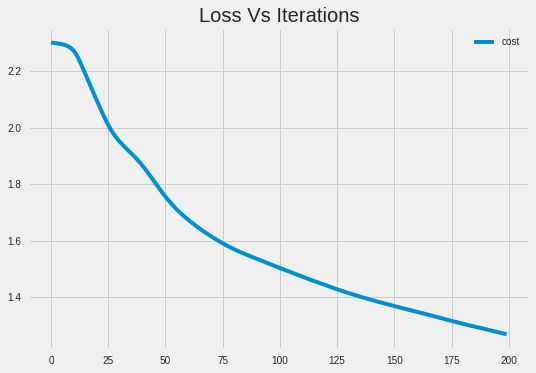

In [6]:
layers = [Xtrain.shape[1], 512, 256, 10]
nn = NeuralNetwork(layers)
nn.train(Xtrain, ytrain, 200, 0.001, 100, 10)
nn.summary()

In [0]:
pLabels = nn.predict(Xtest.T)
save_predictions('ans1-ryk248.npy', pLabels)
save_predictions('ans1-ak6384.npy', pLabels)

In [13]:
print("Accuracy = ", accuracy_score(pLabels,ytest)*100, "%")

Accuracy =  52.690000000000005 %


In [0]:
files.download('ans1-ryk248.npy')
files.download('ans1-ak6384.npy')